# ECE 401 MP5: Discrete Fourier Transform

In this file, we're going to use the inverse DFT to create images from MRI spectral measurements.  Then we'll use the DFT to filter out noise in an image.

In [1]:
import os, h5py
import numpy as np
import matplotlib.figure
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
import submitted

## 0. Data

The data are provided for you in the file `data.hdf5`.  Let's load it, and see what it contains.

In [2]:
with h5py.File('data.hdf5','r') as f:
    print('data.hdf5 has the keys',f.keys())
    mri_dft = f['mri_dft'][:]
    image = f['image'][:]
    noisy_image = f['noisy_image'][:]
print('mri_dft is an array of shape',mri_dft.shape,'and dtype',mri_dft.dtype)
print('image is an array of shape',image.shape,'and dtype',image.dtype)
print('noisy_image is an array of shape',noisy_image.shape,'and dtype',noisy_image.dtype)

data.hdf5 has the keys <KeysViewHDF5 ['image', 'mri_dft', 'noisy_image']>
mri_dft is an array of shape (1114, 962) and dtype complex128
image is an array of shape (213, 320, 3) and dtype float64
noisy_image is an array of shape (213, 320, 3) and dtype float64


## 1. MRI

MRI (magnetic resonance images) are acquired in the frequency domain.  It works roughly like this:

1. Every atom in your body spins, all the time, emitting weak radio signals.  A strong magnetic field will align a few percent of them all in the same direction, so that their radio signals can be measured.
2. If the external magnetic field slightly different in different locations, then the synchronized spin will be at slightly different frequencies in different locations.  By holding this difference for a carefully controlled amount of time, we can set it up so that your atoms are spinning with slightly different phases  in different locations.  The phase at location $(n_1,n_2)$ might be tweaked to be $\phi=-\omega_1n_1-\omega_2n_2$.
3. If the density of hydrogen atoms at location $(n_1,n_2)$ is given by $x[n_1,n_2]$, then the total signal collected is

$$X(\omega_1,\omega_2) = \sum_{n_1}\sum_{n_2} x[n_1,n_2] e^{-j\omega_1 n_1}e^{-j\omega_2 n_2}$$

4. After measuring $X(\omega_1,\omega_2)$ at $N_1$ different values of $\omega_1$, and $N_2$ different values of $\omega_2$, then we compute the inverse DFT in order to calculate the image.

The image you  are provided, `mri_dft`, is a  set of complex-valued frequency samples from a real MRI image (https://commons.wikimedia.org/wiki/File:T1-weighted-MRI.png).  Let's try taking the inverse DFT, to see if we  can  see the image.


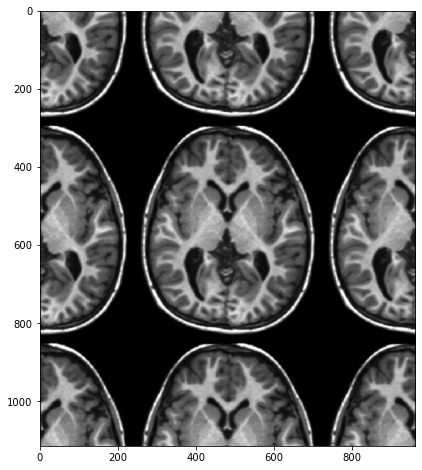

In [3]:
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(np.maximum(0,np.real(np.fft.ifft2(mri_dft))), cmap='gray')


The aliasing we see, here, is caused by capturing only $N_1\times N_2$ frequency samples, but computing the DFT using a spatial range  $M_1\times M_2$ such that $M_1>N_1$ and/or $M_2>N_2$.  By doing that, we accidentally discover that the DFT is periodic in **space**, not just in **frequency**:

$$x[N+n] = \frac{1}{N}\sum_k X[k]e^{j\frac{2\pi k(n+N)}{N}} = \frac{1}{N}\sum_k X[k]e^{j\frac{2\pi kn}{N}} =x[n]$$

In order to solve this problem, we need to figure out how many of the frequency samples in `mri_dft` are actually  nonzero-valued.  To get an idea, let's try plotting the first row:

<StemContainer object of 3 artists>

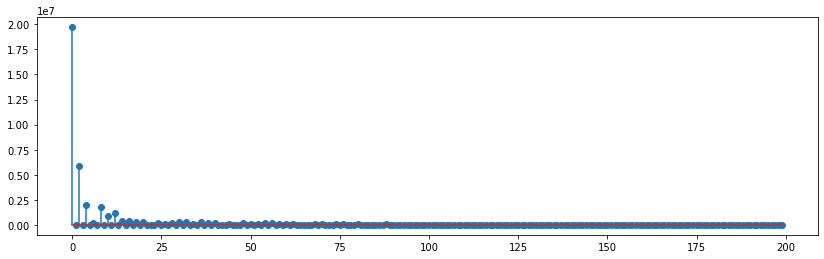

In [4]:
fig, ax = plt.subplots(figsize=(14,4))
ax.stem(np.abs(mri_dft[0,0:200]))

It looks like maybe the odd-numbered spectral samples are zero, and only the even-numbered spectral samples are valid.  Let's try taking the inverse fft of only the even-numbered samples.

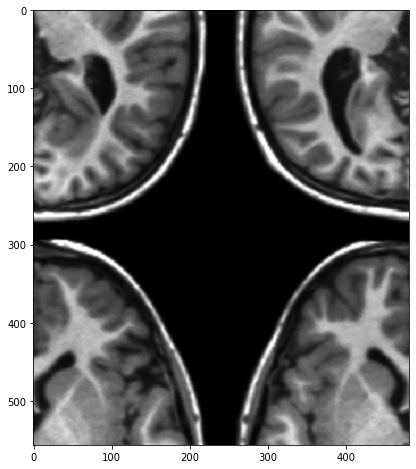

In [5]:
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(np.real(np.fft.ifft2(mri_dft[::2,::2])), cmap='gray')

That's the right size, but now the whole image has been shifted by about $N_1/2$ rows, and  by about  $N_2/2$ columns!  One  way to solve this is by multiplying the DFT by a shift operator, before we inverse  DFT:

$$X_{\mbox{corrected}}[k_1,k_2] = 
\begin{cases}
X[k_1,k_2] e^{-j\frac{2\pi k_1d_1}{N_1}}e^{-j\frac{2\pi k_2d_2}{N_2}} & 0\le k_1<\frac{N_1}{2},~0\le k_2<\frac{N_2}{2}\\
X[k_1,k_2] e^{-j\frac{2\pi (k_1-N_1)d_1}{N_1}}e^{-j\frac{2\pi (k_2-N_2)d_2}{N_2}} &\frac{N_1}{2}\le k_1<N_1,~\frac{N_2}{2}\le k_2<N_2
\end{cases}
$$

where $d_1$ is the number of rows that we want to shift, and $d_2$ is the number of columns that we want to shift.
Notice that the second line is actually equal to the first line, in theory (because $e^{-j\frac{2\pi N_1d_1}{N_1}}=1$), but implementing it in the way shown above will help to avoid artifacts caused by floating-point roundoff error.  Notice that the formula above only lists two of the four cases; I think you can figure out what the other two cases should be.

In [6]:
importlib.reload(submitted)
help(submitted.downsample_and_shift_dft2)

Help on function downsample_and_shift_dft2 in module submitted:

downsample_and_shift_dft2(oversampled_dft, downsampling_factor, row_shift, col_shift)
    Input: 
      oversampled_dft [M1,M2] - a 2d array containing the oversampled DFT of a grayscale image
      downsampling_factor (scalar) - the factor by which the DFT image is oversampled
      row_shift (scalar)  - the number of rows that the image should be shifted
      col_shift (scalar) - the number of columns that the image should be shifted
    Output: 
      image [M1/downsampling_factor, M2/downsampling_factor] - the real part of the inverse DFT
      of the valid frequency samples, shifted by the specified numbers of rows and columns.



1114 962
solutions.hdf5 has the keys <KeysViewHDF5 ['cleaned_image', 'mirrored_image', 'mri', 'transitioned_image']>


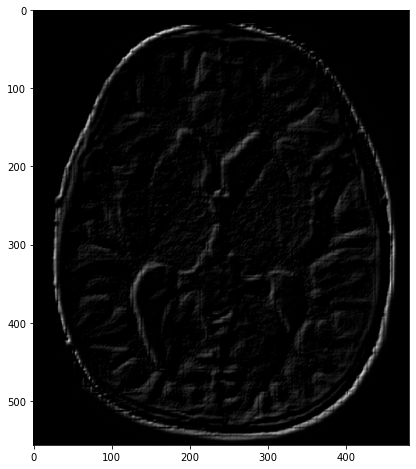

In [7]:
importlib.reload(submitted)
N1, N2 = mri_dft.shape
print(N1,N2)
image = submitted.downsample_and_shift_dft2(mri_dft,2,-N1/4,-N2/4)
with h5py.File('solutions.hdf5','r') as f:
    print('solutions.hdf5 has the keys',f.keys())
    cleaned_image = f['mri'][:]

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(np.maximum(0,np.minimum(255,image-cleaned_image)),cmap='gray')

## 2. Noisy Image

Filtering out noise is easier in the time domain, if the noise is wideband noise (meaning that there is noise in a wide range of frequencies).  Sometimes, though, the noise is in a narrow range of frequencies.  For example, consider this image:

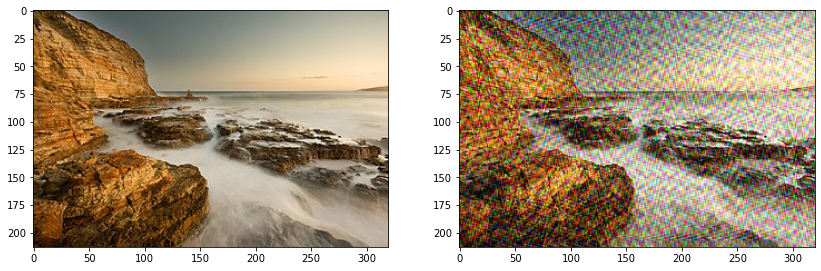

In [8]:
with h5py.File('data.hdf5','r') as f:
    image = f['image'][:]
    noisy_image = f['noisy_image'][:]
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(image)
ax[1].imshow(noisy_image)


You can see that the noisy image has been corrupted with some type of random stripes.  Let's see what the DFT looks like.

Normally, it might be hard to figure out where the noise is.  Since we have the original image, though, we can calculate the signal-to-noise ratio in each FFT bin.

Text(0.5, 1.0, 'SNR as a function of bin, Green Channel, across columns, zoomed in')

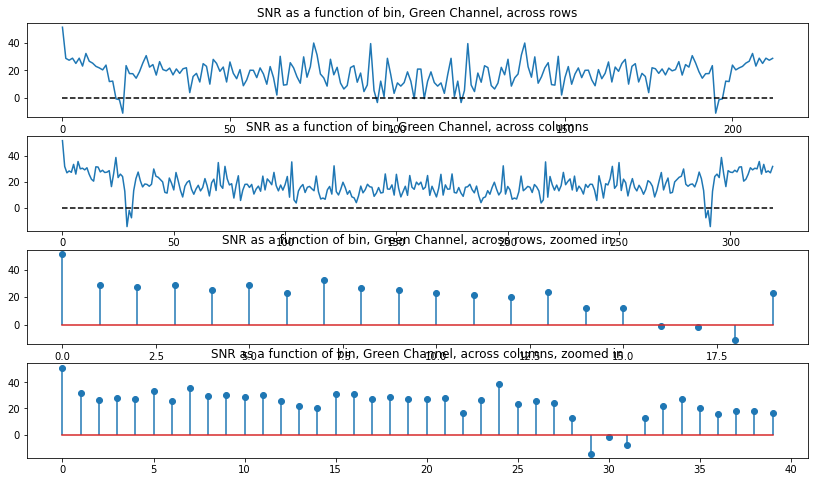

In [9]:
fig, axs = plt.subplots(4,1,figsize=(14,8))
image_dft = np.fft.fft2(image,axes=(0,1))
noisy_dft = np.fft.fft2(noisy_image, axes=(0,1))
noise = noisy_dft - image_dft
M,N,K = noisy_dft.shape
axs[0].plot(20*np.log10(np.abs(image_dft[:,0,1]/noise[:,0,1])))
axs[0].plot(np.arange(M),np.zeros(M),'k--')
axs[0].set_title('SNR as a function of bin, Green Channel, across rows')
axs[1].plot(20*np.log10(np.abs(image_dft[0,:,1]/noise[0,:,1])))
axs[1].plot(np.arange(N),np.zeros(N),'k--')
axs[1].set_title('SNR as a function of bin, Green Channel, across columns')
axs[2].stem(20*np.log10(np.abs(image_dft[:20,0,1]/noise[:20,0,1])))
axs[2].set_title('SNR as a function of bin, Green Channel, across rows, zoomed in')
axs[3].stem(20*np.log10(np.abs(image_dft[0,:40,1]/noise[0,:40,1])))
axs[3].set_title('SNR as a function of bin, Green Channel, across columns, zoomed in')



It looks like the signal-to-noise ratio is lowest in the bands $16\le k_1< 19$, $N_1-19<k_1\le N_1-16$, $29\le k_2<32$, and $N_2-32<k_2\le N_2-29$.

We could get rid of this noise by using an ideal bandstop filter, as in MP4.  Instead, this time, let's try to get rid of it using the DFT.

Let's try to get rid of the noise by just zeroing out those channels.  Implement the `dft_filter` function, with the following description:

$$X_{\mbox{corrected}}[k_1,k_2]=\begin{cases}
0 & \mbox{min}_1\le (k_1~\mbox{or}~N_1-k_1)<\mbox{max}_1\\
0 & \mbox{min}_2\le (k_2~\mbox{or}~N_2-k_2)<\mbox{max}_2\\
X[k_1,k_2] & \mbox{otherwise}
\end{cases}
$$

where $\mbox{min}_1$, $\mbox{max}_1$, $\mbox{min}_2$, and $\mbox{max}_2$ are band edges.

In [10]:
importlib.reload(submitted)
help(submitted.dft_filter)

Help on function dft_filter in module submitted:

dft_filter(noisy_image, min1, max1, min2, max2)
    Input: 
      noisy_image [N1,N2] - an image with narrowband noises
      min1, max1 (scalars) - zero out all rows of the DFT min1 <= k1 < max1, likewise  for N1-k1
      min2, max2 (scalars) - zero out all cols  of the DFT min2 <= k2 < max2, likewise for N2-k2
    Outut:
      cleaned_image [N1,N2] - image with the corrupted bands removed.
      Be sure to take the real part of the inverse DFT, and then truncate
      so that 0 <= cleaned_image[n1,n2,color] <= 1 for all n1,n2,color.



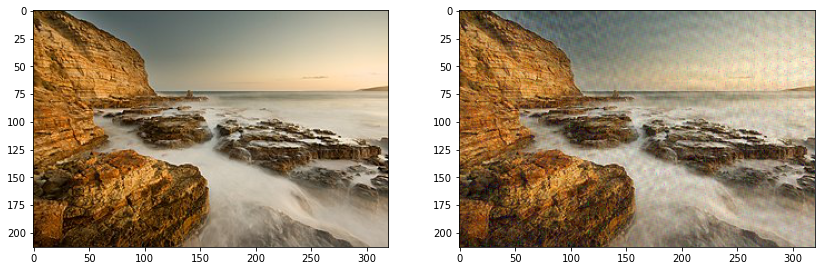

In [11]:
importlib.reload(submitted)
cleaned_image = submitted.dft_filter(noisy_image,16,19,29,32)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(image)
ax[1].imshow(cleaned_image)

## 3. Image Mirroring

There are many artifacts in the "cleaned" image, but perhaps the  worst one is the set of vertical stripes on the right-hand edge.  Where do those stripes come from?

In order to understand this, remember that the inverse DFT of multiplication is not **convolution**, but **circular convolution**.  In other words, multiplying in the DFT domain is like convolving an ideal bandstop filter together with the periodic repetition of the original image.

We can explore this by explicitly creating a periodic repetition of the input image, then applying the narrowband filter to it.

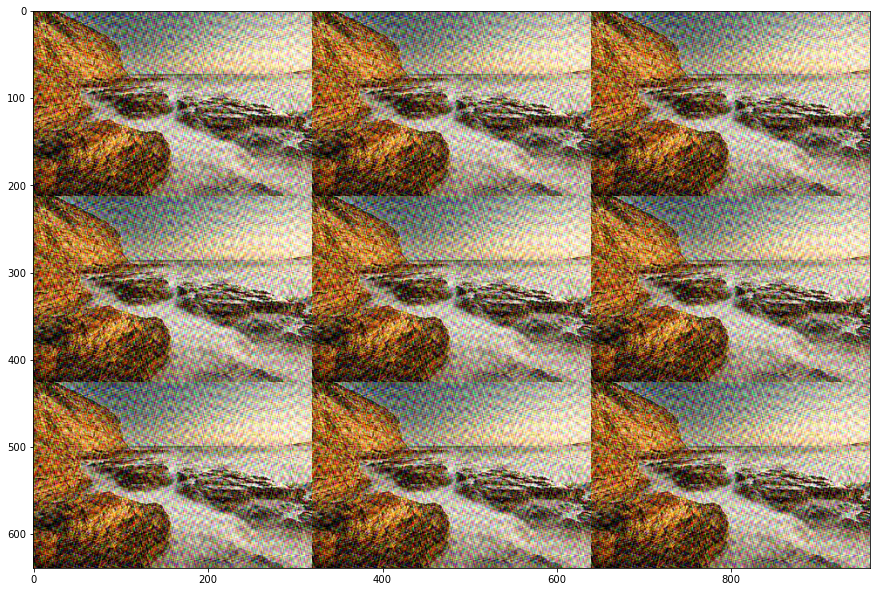

In [12]:
periodic_repetition = np.tile(noisy_image, reps=(3,3,1))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(periodic_repetition)

If we filter this periodic repetition, the results should be **exactly the same** as if we filter just one single image.  Let's check that:

In [13]:
importlib.reload(submitted)
cleaned_repetition = submitted.dft_filter(periodic_repetition,3*16,3*19,3*29,3*32)
N1,N2,N3 = cleaned_image.shape
difference = cleaned_image - cleaned_repetition[:N1,:N2,:N3]
print('cleaned_repetition and cleaned_image differ by:',np.sum(np.abs(difference)))


cleaned_repetition and cleaned_image differ by: 4.523148418718271e-11


Filtering the single image is exactly the same as filtering the periodic repetition. For that reason, we can immediately see where the vertical stripe on the **right-hand side** of the cleaned image comes from: it is a sidelobe of the sinc function (the ideal band-stop filter), resulting from the sharp edge between the right-hand side and the **left-hand side** of the image:

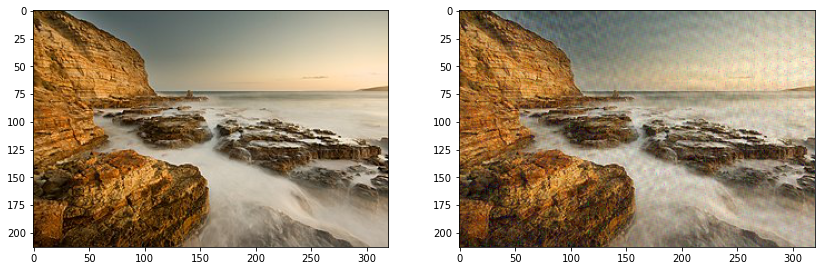

In [14]:
importlib.reload(submitted)
cleaned_image = submitted.dft_filter(noisy_image,16,19,29,32)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(image)
ax[1].imshow(cleaned_repetition[:N1,:N2,:])

One way to reduce the brightness of that artifact is by mirroring the image, so that the periodic repetition is more sensible.  Then we filter the mirrored image, and then extract the original image out  of the result.

In [15]:
importlib.reload(submitted)
help(submitted.create_mirrored_image)

Help on function create_mirrored_image in module submitted:

create_mirrored_image(image)
    Input:
      image [N1,N2,N3] - an original image that you  want to filter.
    Output:
      mirrored_image [2*N1, 2*N2, N3] - an image containing mirrored copies of the original,
      left-to-right and top-to-bottom, so that there is no sudden change of color at any of the
      original edges of the image.



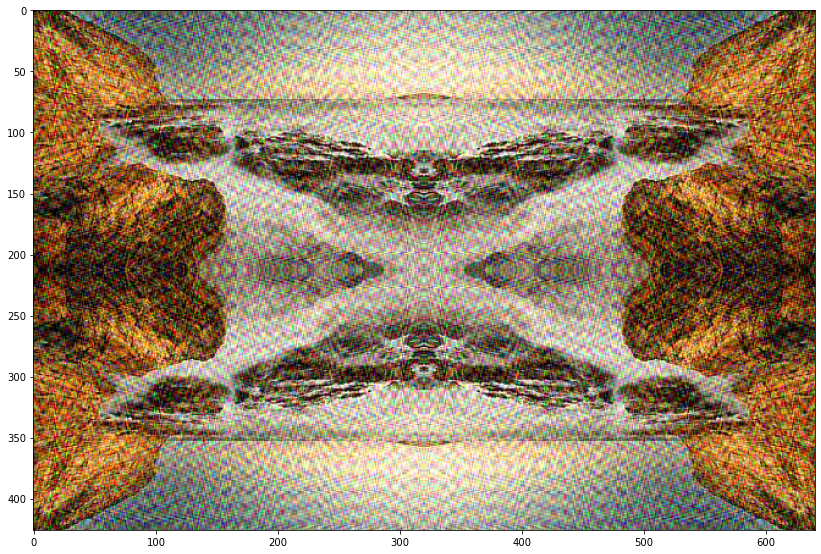

In [16]:
importlib.reload(submitted)
mirrored_image = submitted.create_mirrored_image(noisy_image)
fig, ax = plt.subplots(figsize=(14,14))
ax.imshow(mirrored_image)

Now, if we bandstop filter this image, we shouldn't get the bright sidelobe-of-sinc artifact stripe on the right edge, because there is no sudden color change on the right edge.

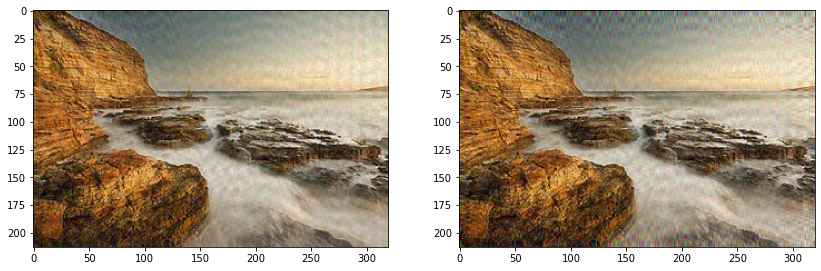

In [17]:
importlib.reload(submitted)
cleaned_mirrored = submitted.dft_filter(mirrored_image,2*16-1,2*19,2*29-1,2*32)
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].imshow(cleaned_image)
ax[1].imshow(cleaned_mirrored[:N1,:N2,:])

## 4. Transition Band

As shown above, mirroring the image reduces the strong stripe effects on the right-hand side, but it seems to strengthen the ripple artifacts throughout the rest of the image.

Remember that, when we were using ideal filters, similar ripple artifacts were caused by truncating the impulse response using  a rectangular window.  The way we avoided ripple artifacts then was by using a  Hamming window instead.

One important difference between a Hamming window and a rectangular window is that the Hamming window has a wider transition band.  So let's introduce a transition band into our filter:

$$X_{\mbox{corrected}}[k_1,k_2]=\begin{cases}
0 & \mbox{min}_1\le (k_1~\mbox{or}~N_1-k_1)<\mbox{max}_1\\
0 & \mbox{min}_2\le (k_2~\mbox{or}~N_2-k_2)<\mbox{max}_2\\
\frac{1}{2}X[k_1,k_2] & k_1\in\left\{\mbox{min}_1-1,\mbox{max}_1\right\}\\
\frac{1}{2}X[k_1,k_2] & k_2\in\left\{\mbox{min}_2-1,\mbox{max}_2\right\}\\
X[k_1,k_2] & \mbox{otherwise}
\end{cases}
$$

In [18]:
importlib.reload(submitted)
help(submitted.transitioned_filter)

Help on function transitioned_filter in module submitted:

transitioned_filter(noisy_image, min1, max1, min2, max2)
    Input: 
      noisy_image [N1,N2] - an image with narrowband noises
      min1, max1 (scalars) - zero out all rows of the DFT min1 <= k1 < max1, likewise  for N1-k1
      min2, max2 (scalars) - zero out all cols  of the DFT min2 <= k2 < max2, likewise for N2-k2
    Outut:
      cleaned_image [N1,N2] - image with the corrupted bands removed.
      Be sure to take the real part of the inverse DFT, and then truncate
      so that 0 <= cleaned_image[n1,n2,color] <= 1 for all n1,n2,color.
    
    Transition band:
      the bands k1=min1-1, k1=max1, k2=min2-1, and k2=max2 should be set to half of their
      original values, 0.5*X[k1,k2].



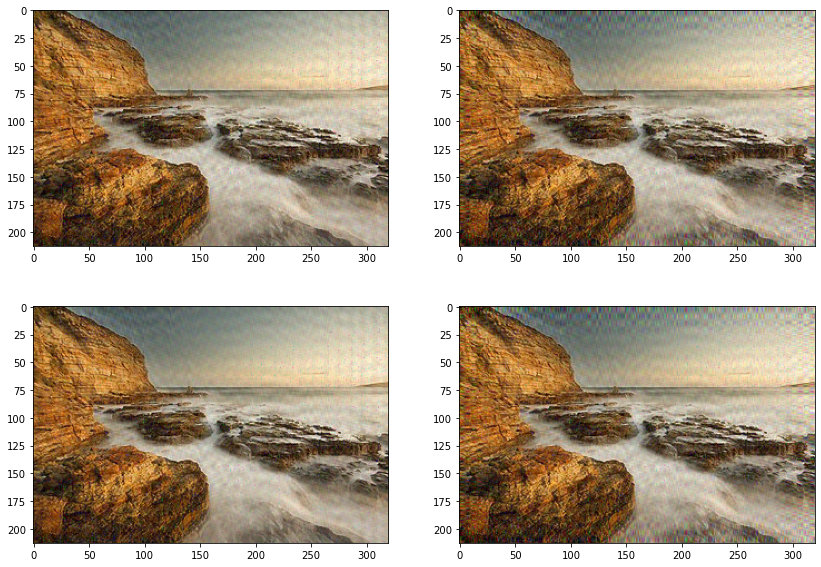

In [20]:
importlib.reload(submitted)
transitioned_image = submitted.transitioned_filter(noisy_image,16,19,29,32)
transitioned_mirrored = submitted.transitioned_filter(mirrored_image,2*16-1,2*19,2*29-1,2*32)
fig, ax = plt.subplots(2,2,figsize=(14,10))
ax[0,0].imshow(cleaned_image)
ax[0,1].imshow(cleaned_mirrored[:N1,:N2,:])
ax[1,0].imshow(transitioned_image)
ax[1,1].imshow(transitioned_mirrored[:N1,:N2,:])

TBH, it's a little hard to tell which cleaned-up image is best.  Let's calculate their signal-to-noise ratios, in decibels.

In [21]:
error1 = cleaned_image - image
SNR1 = 20*np.log10(np.sum(np.square(image))/np.sum(np.square(error1)))
error2 = cleaned_mirrored[:N1,:N2,:] - image
SNR2 = 20*np.log10(np.sum(np.square(image))/np.sum(np.square(error2)))
error3 = transitioned_image - image
SNR3 = 20*np.log10(np.sum(np.square(image))/np.sum(np.square(error3)))
error4 = transitioned_mirrored[:N1,:N2,:] - image
SNR4 = 20*np.log10(np.sum(np.square(image))/np.sum(np.square(error4)))
print('The four SNRs are %g, %g, %g, and %g'%(SNR1,SNR2,SNR3,SNR4))

The four SNRs are 42.4523, 38.8578, 43.0536, and 39.06


## Conclusion

Higher SNR is better, so it seems that the best solution, in this case, is the filter:
* with a transition band, but
* without using  image mirroring

If you have all of the parts above working, then  you should be able to run `python grade.py` to check your results against the reference solutions.  If you get good results, you can upload your solution to gradescope.